In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3"

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed
from keras.layers.normalization import BatchNormalization
from tqdm import tqdm_notebook, tqdm
from IPython.display import clear_output, display
from keras import backend as K

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

from scipy import stats
from glob import glob
from multiprocessing import Pool
from sklearn.metrics import roc_auc_score as auc
from sklearn.model_selection import StratifiedKFold
import xgboost

Using Theano backend.
/home/billion/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Read data

In [2]:
data = pd.read_csv('./train_labels.csv')
data['train'] = 1

In [3]:
data.head()

SeriesId  Attack  train
0  0_train.csv     0.0      1
1  1_train.csv     0.0      1
2  2_train.csv     1.0      1
3  3_train.csv     0.0      1
4  4_train.csv     1.0      1

In [4]:
files = ['/mnt/kaspersky/data_kasp/train/'+f for f in data.SeriesId][:]
dfs = [pd.read_csv(x, header=None) for x in files]

In [20]:
dfs_1 = [df for df, is_attack in zip(dfs, data.Attack) if  is_attack == 1]
print(len(dfs_1))

185


In [21]:
dfs_0 = [df for df, is_attack in zip(dfs, data.Attack) if  is_attack == 0]
print(len(dfs_0))

315


In [22]:
dfs_0[0].head()

0       1          2          3       4        5        6          7   \
0  24.000  0.2663  3633.1663  4442.4537  9.2072  31.9568  47.5417  2798.7353   
1  24.001  0.2682  3660.4758  4413.0457  9.3156  32.0821  47.1810  2799.7205   
2  24.002  0.2654  3656.2214  4462.4025  9.3413  32.0015  47.6366  2799.8800   
3  24.003  0.2658  3660.0914  4400.2852  9.2219  31.9117  47.1470  2798.7574   
4  24.004  0.2677  3692.9171  4439.1368  9.2656  32.1440  47.4251  2799.5485   

        8         9     ...      46       47       48       49   50       51  \
0  64.4562  122.8972    ...     1.0  24.7195  37.2502  46.4534  1.0  35.9834   
1  65.3930  122.8946    ...     1.0  24.7150  37.2502  46.4540  1.0  35.9503   
2  65.1728  122.8930    ...     1.0  24.7109  37.2494  46.4532  1.0  35.9246   
3  65.2762  122.8939    ...     1.0  24.7067  37.2487  46.4518  1.0  35.9783   
4  65.2813  122.9038    ...     1.0  24.7028  37.2493  46.4527  1.0  35.9234   

        52     53       54        55  
0  13.3898  100.0  12.5809  111.8108  
1  12.5202  100.0  12.4640  111.9069  
2   9.9242  100.0  12.5461  110.4330  
3  14.8768  100.0  12.5240  111.6621  
4  14.9301  100.0  12.5017  110.7714  

[5 rows x 56 columns]

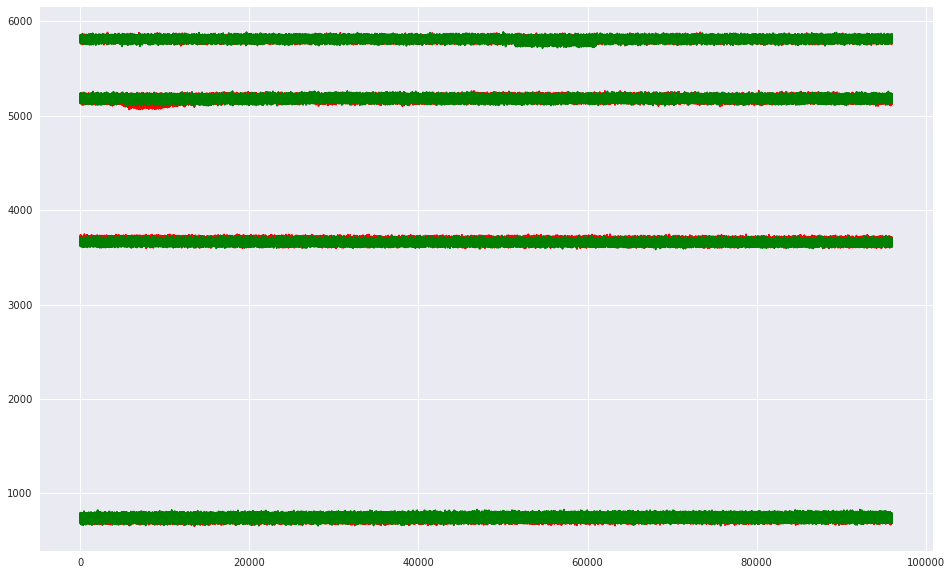

In [51]:
col = 2

dfs_col_0 = np.array([df[col] for df in dfs_0]).T
dfs_col_1 = np.array([df[col] for df in dfs_1]).T

plt.figure(figsize=(16,10))
plt.plot(dfs_col_0[:,:10], c="r")
plt.plot(dfs_col_1[:,:10], c="g")

In [72]:
import time

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


/home/billion/miniconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


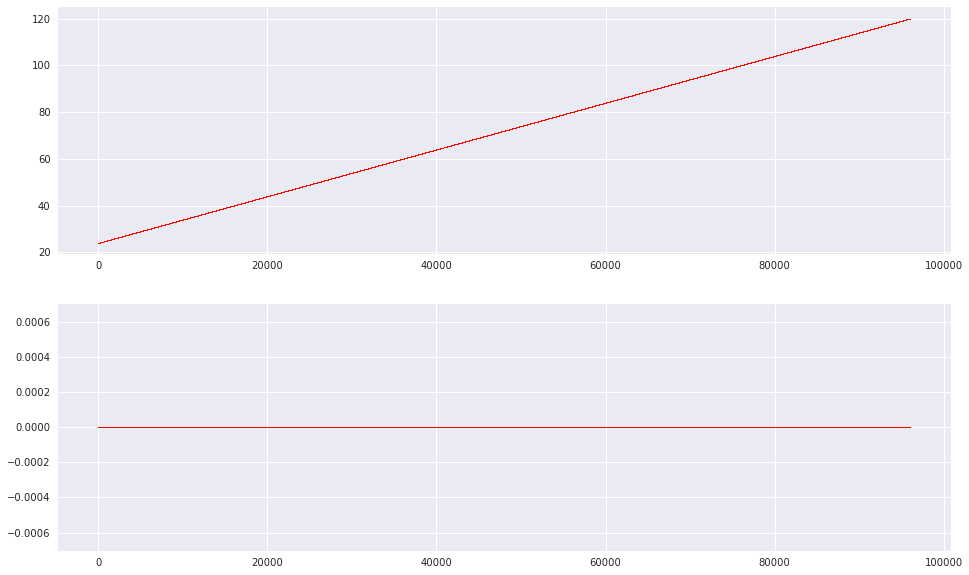

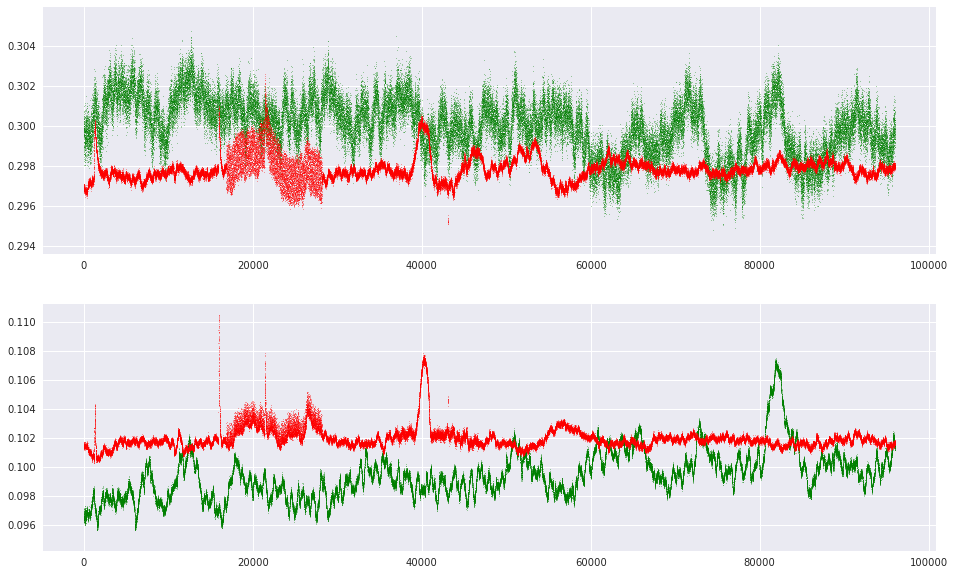

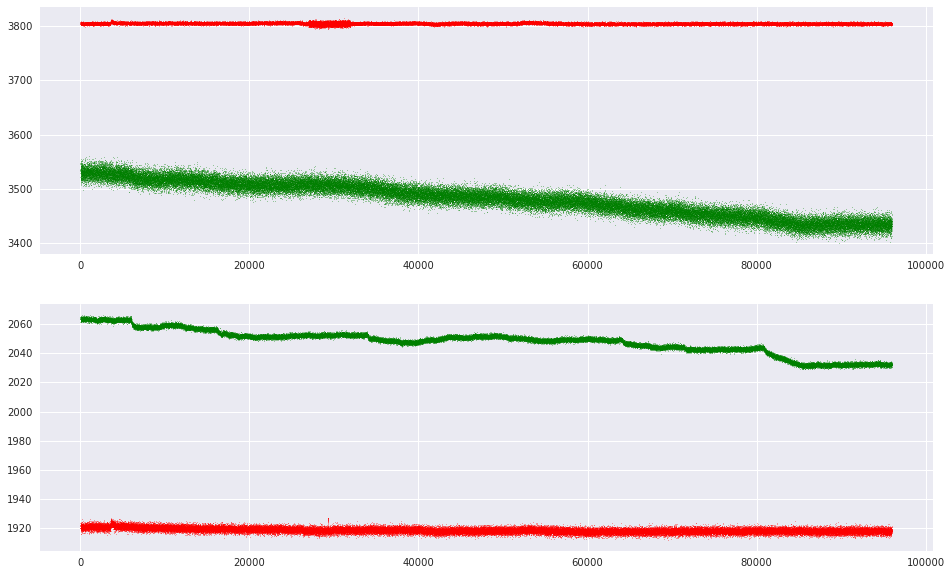

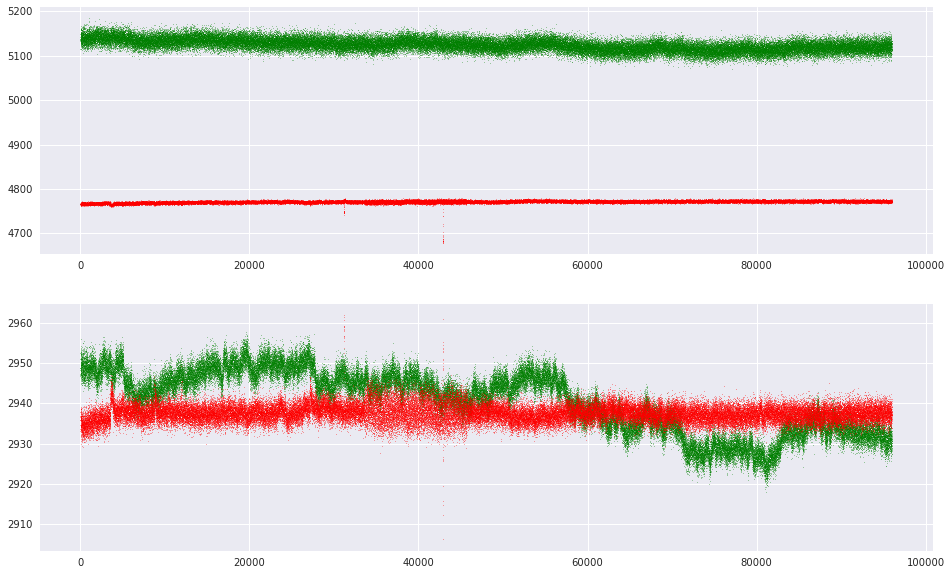

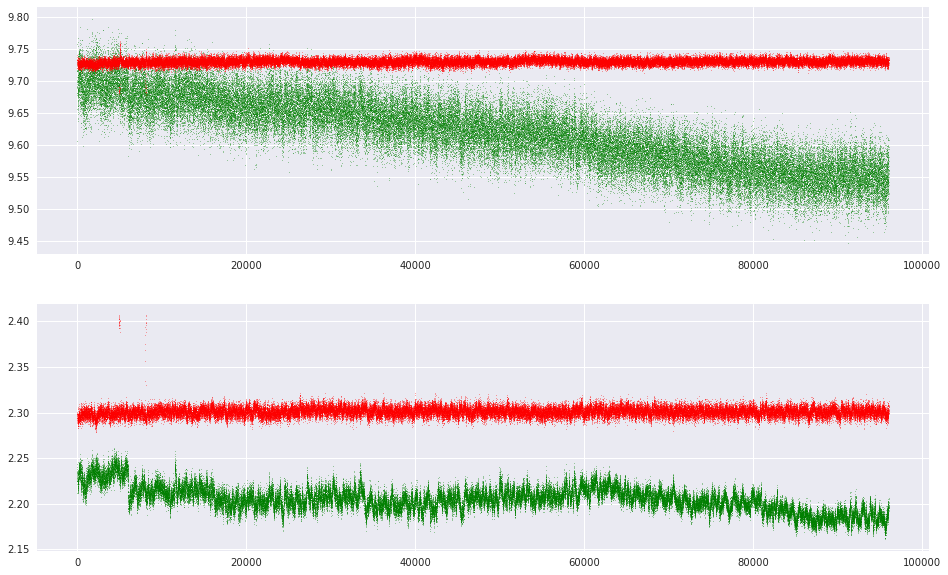

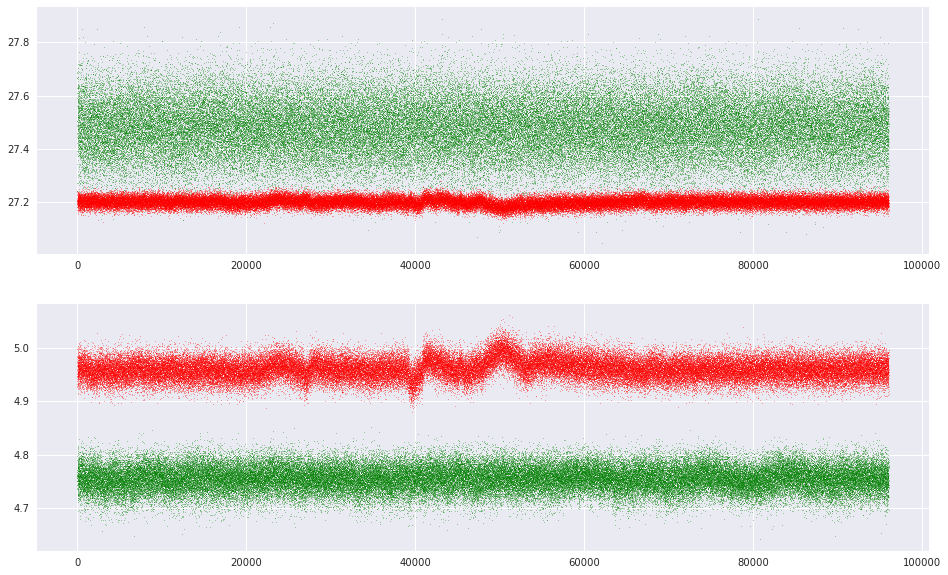

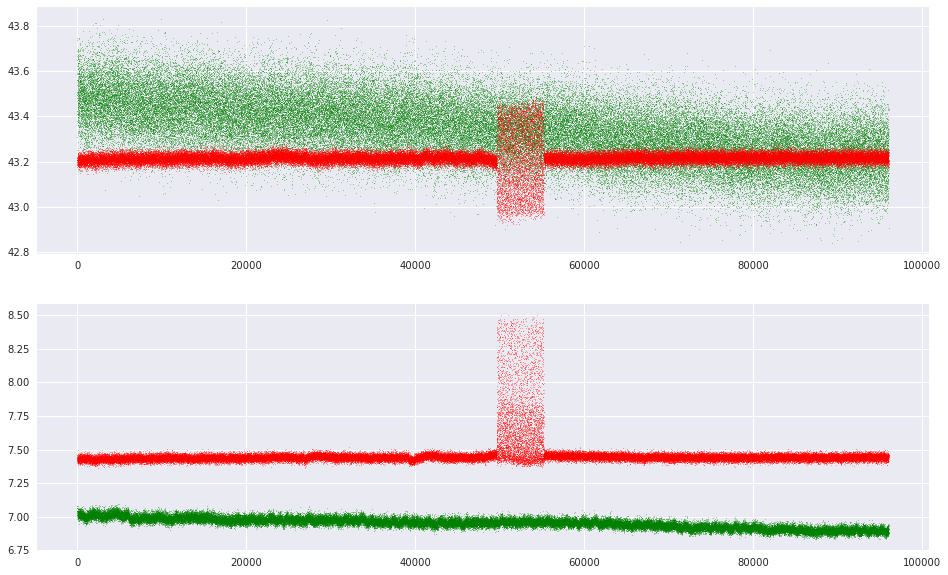

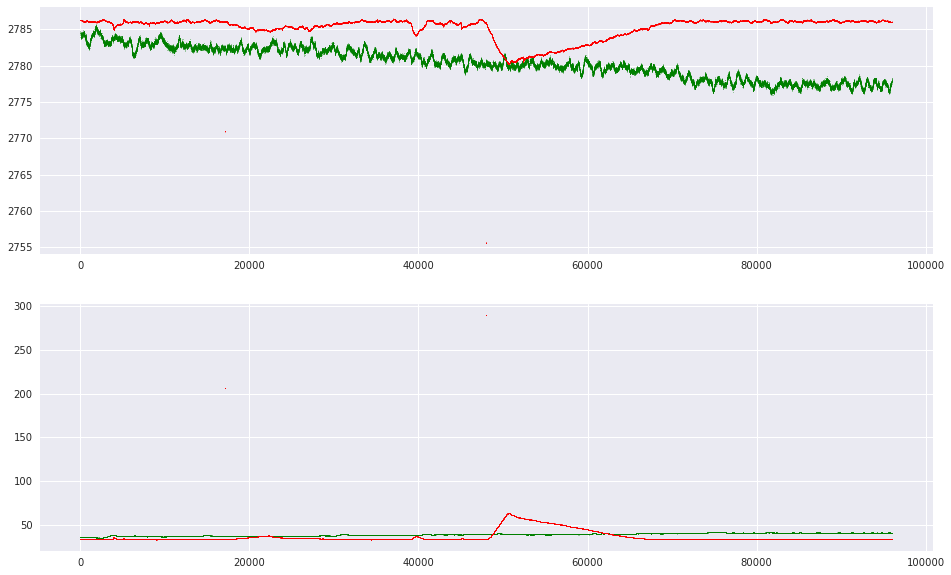

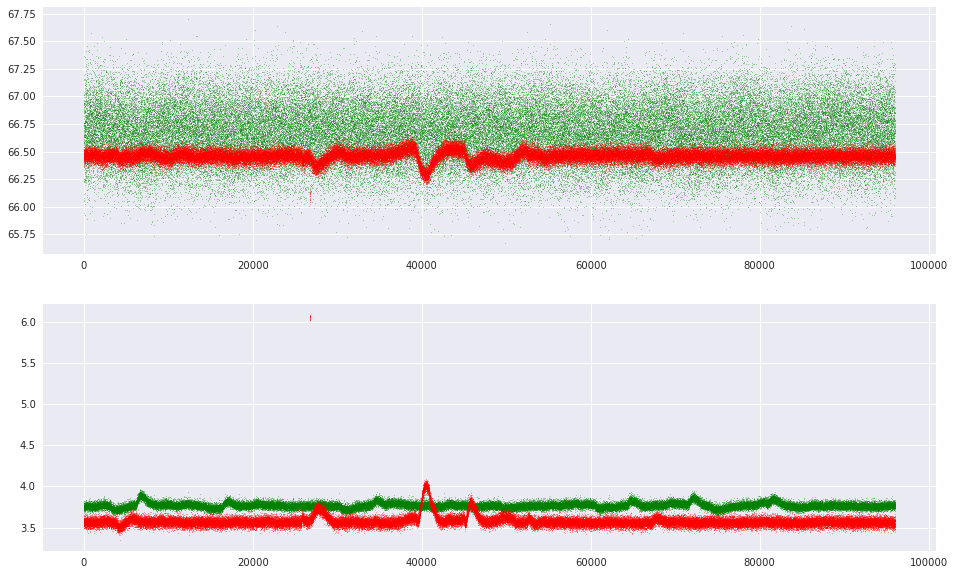

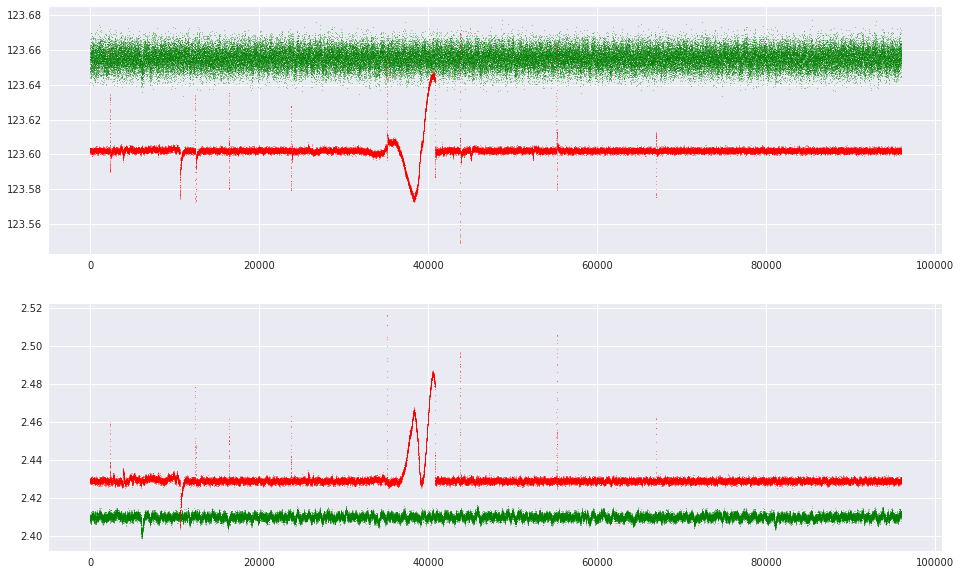

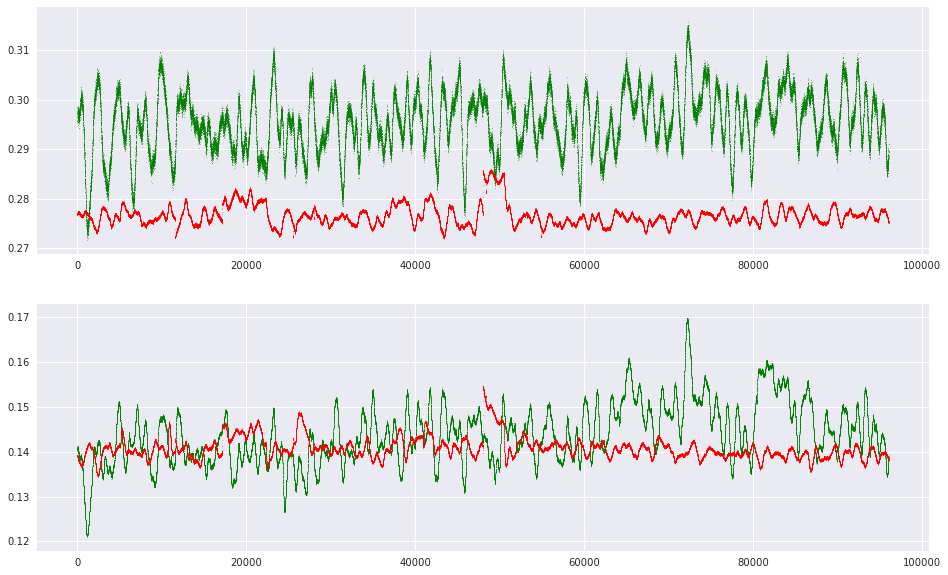

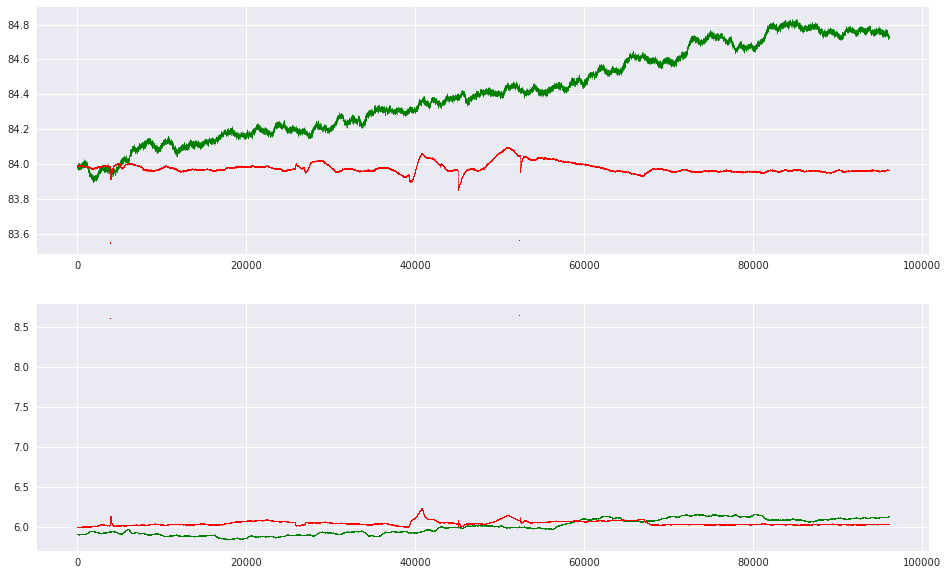

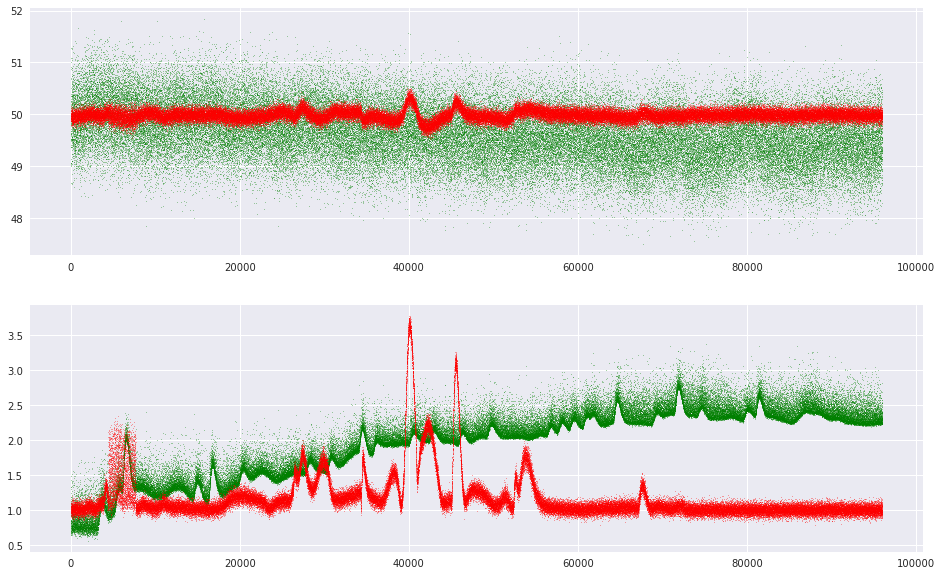

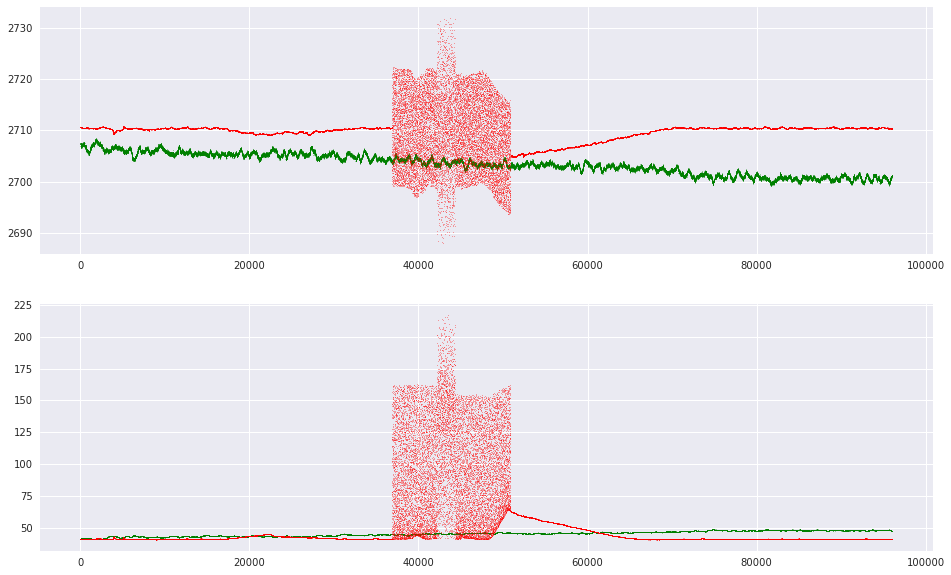

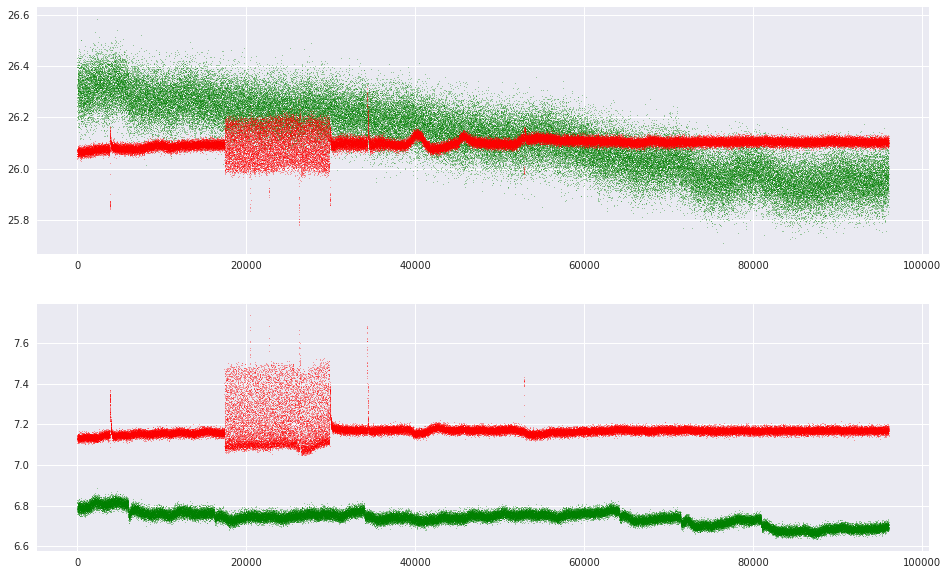

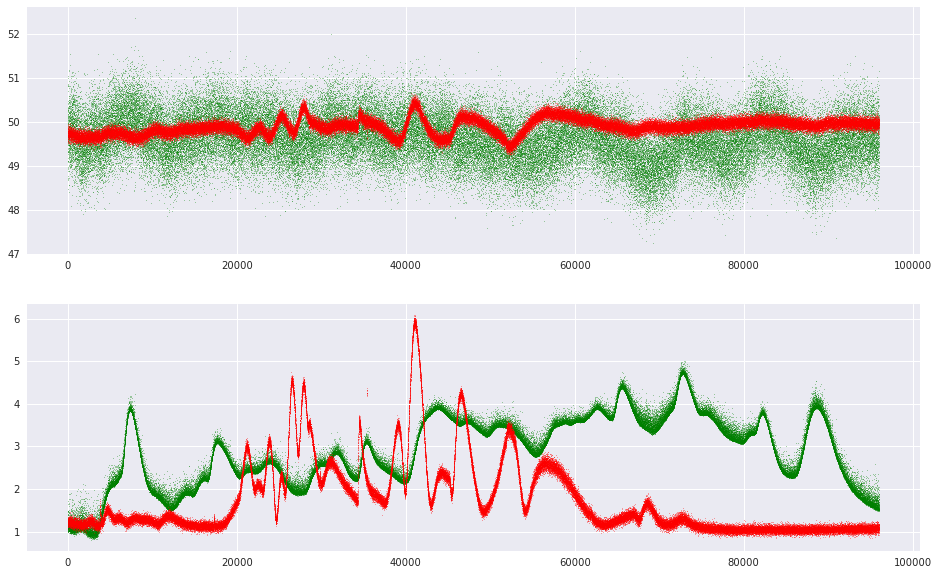

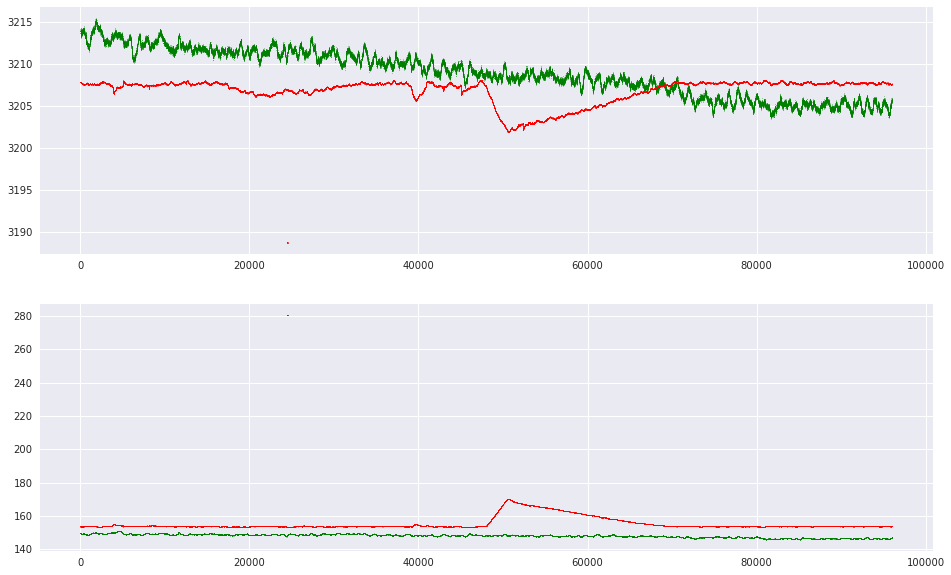

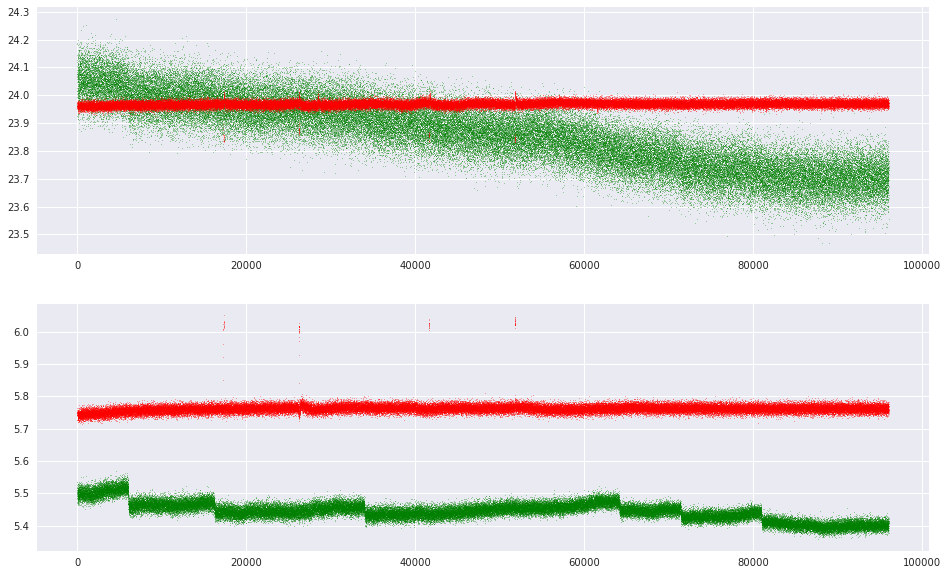

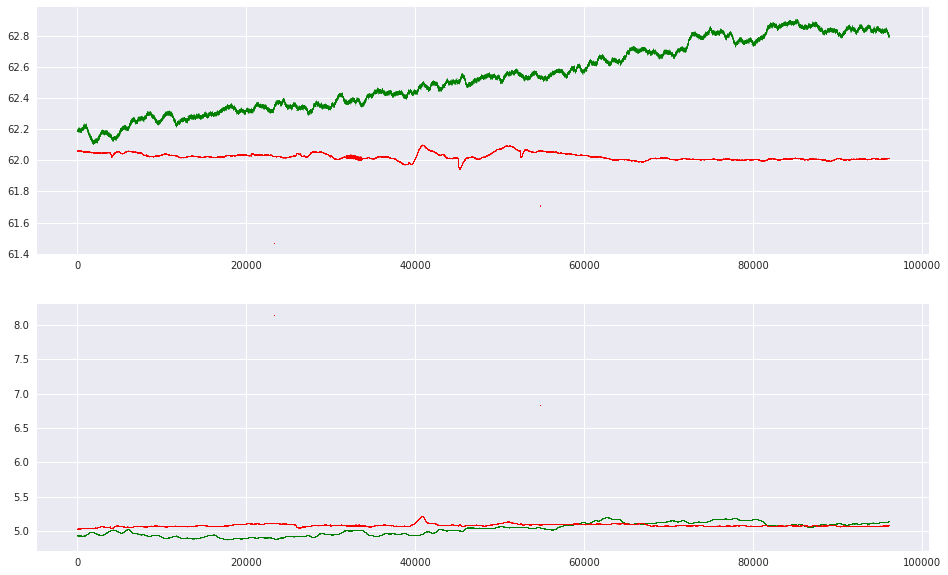

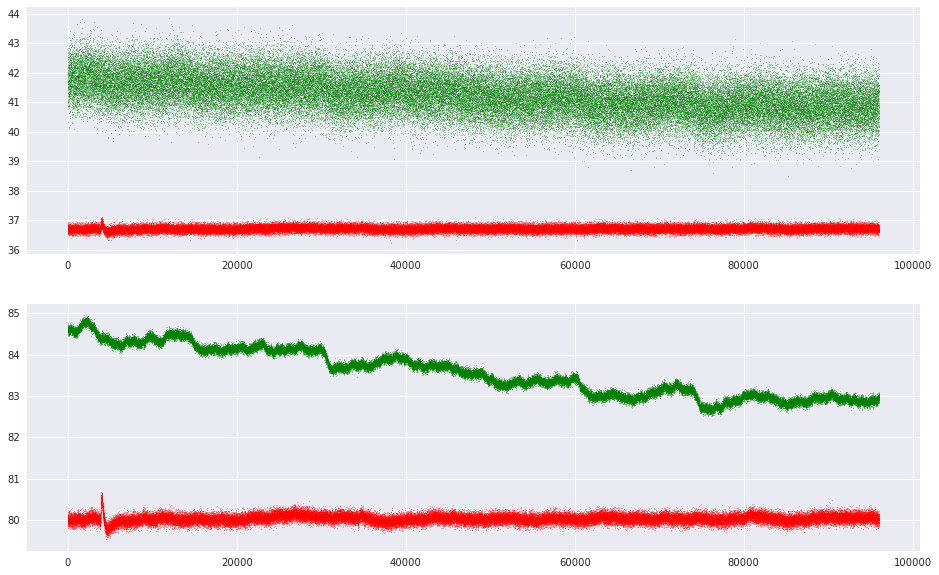

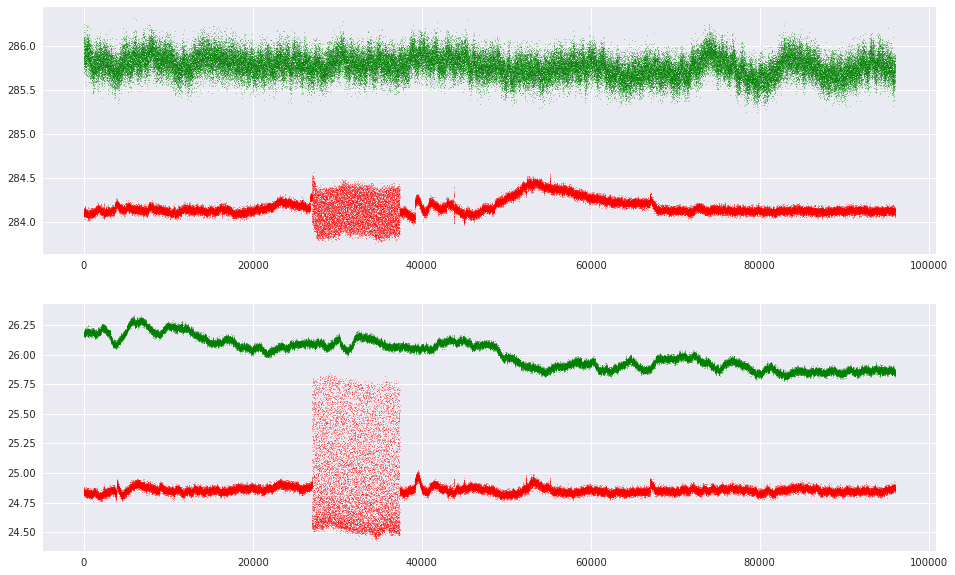

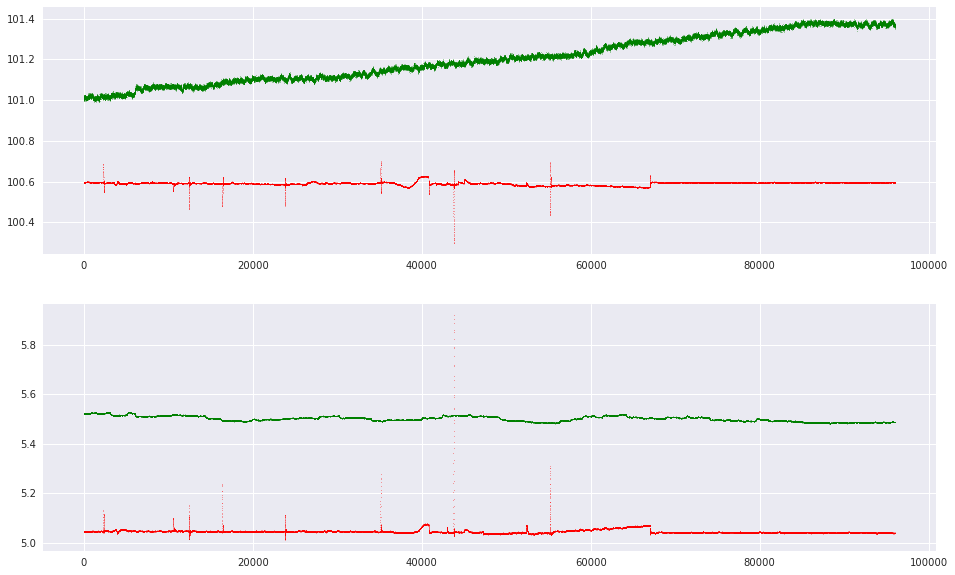

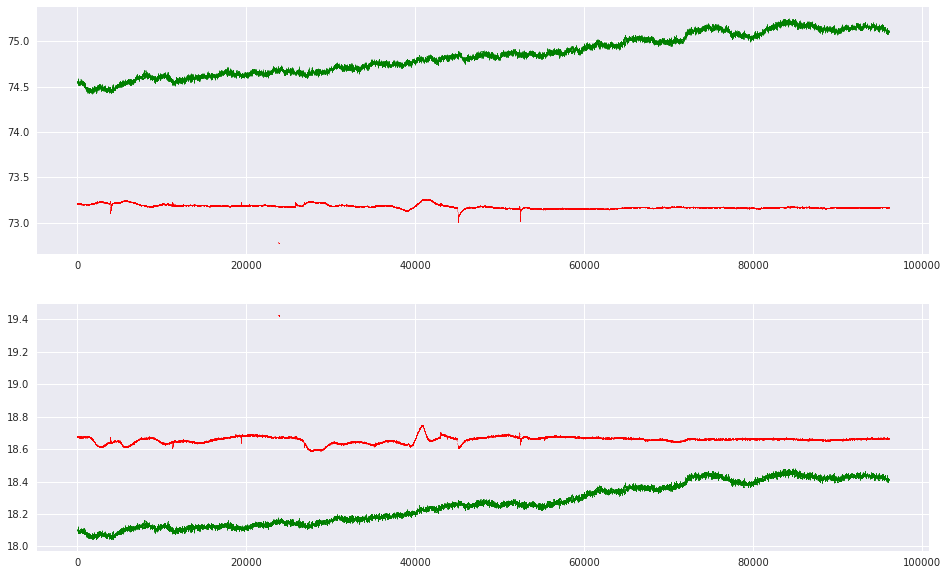

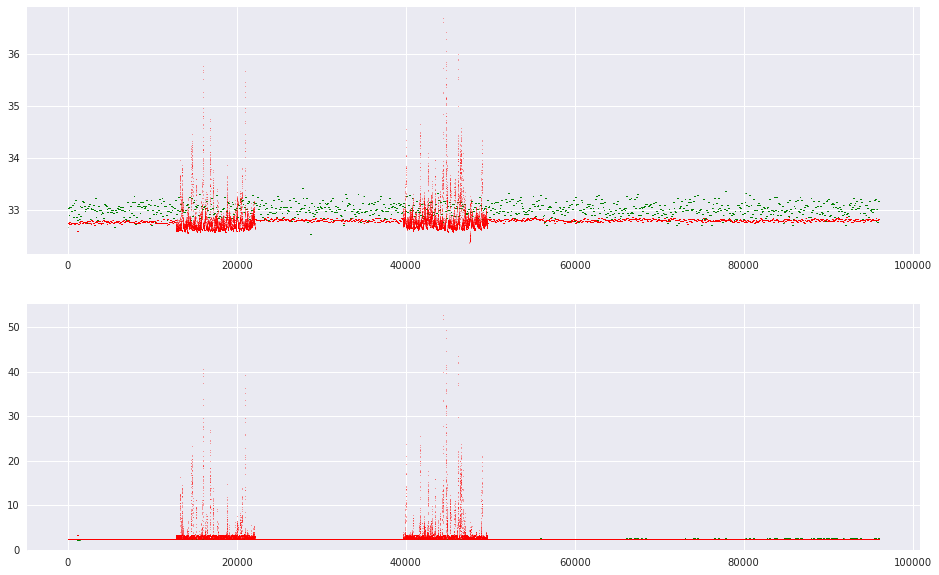

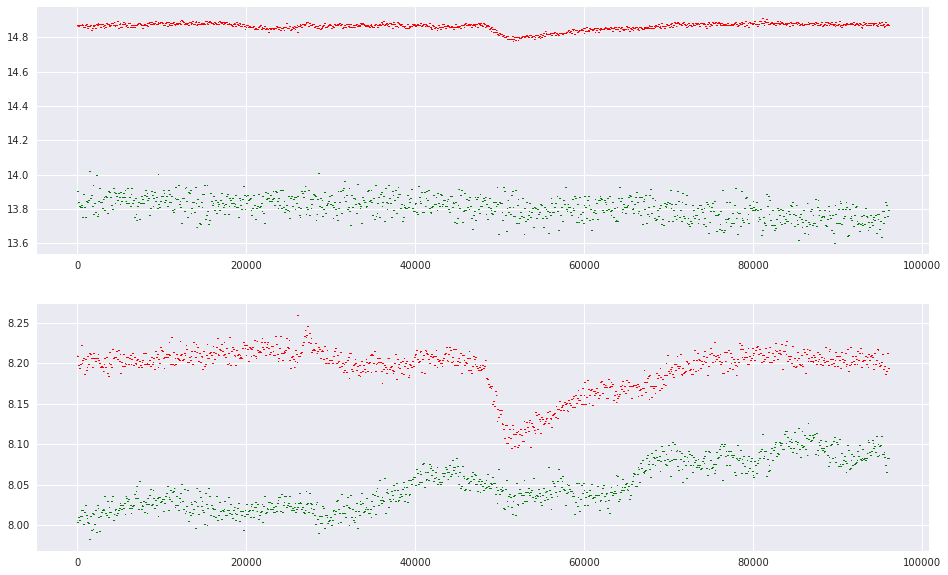

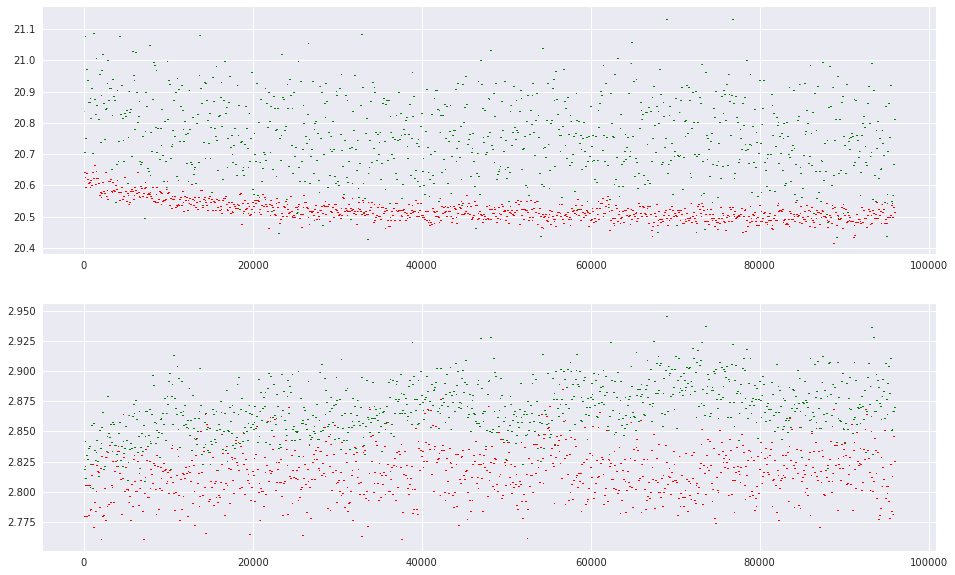

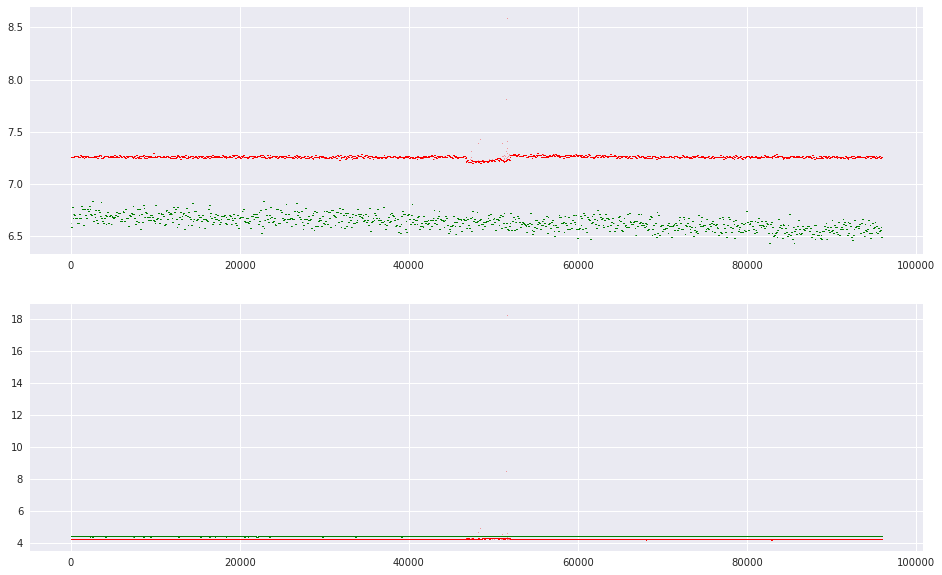

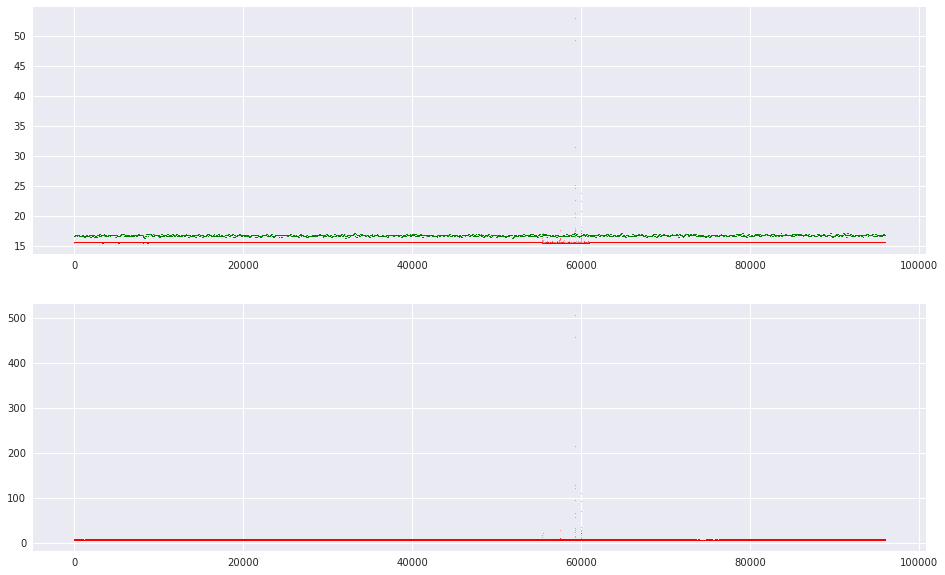

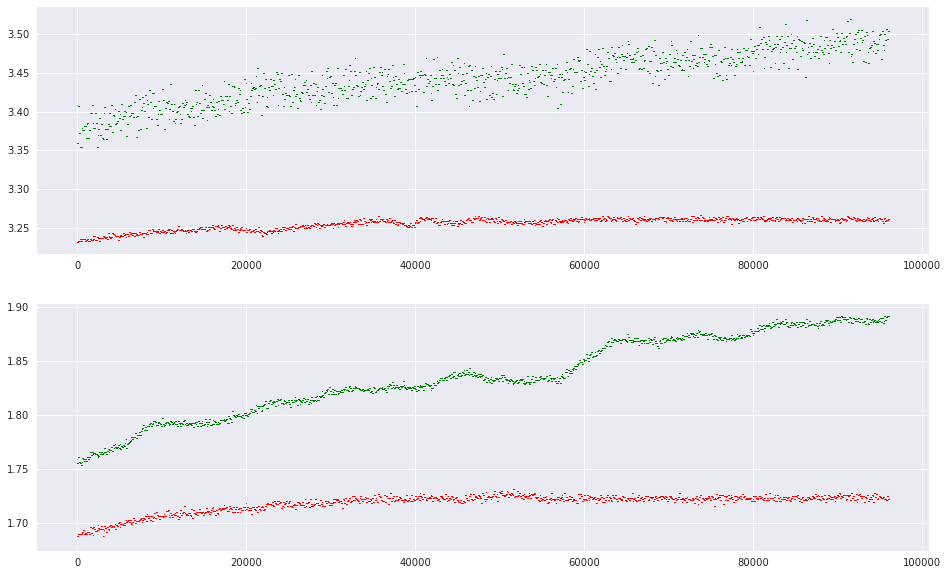

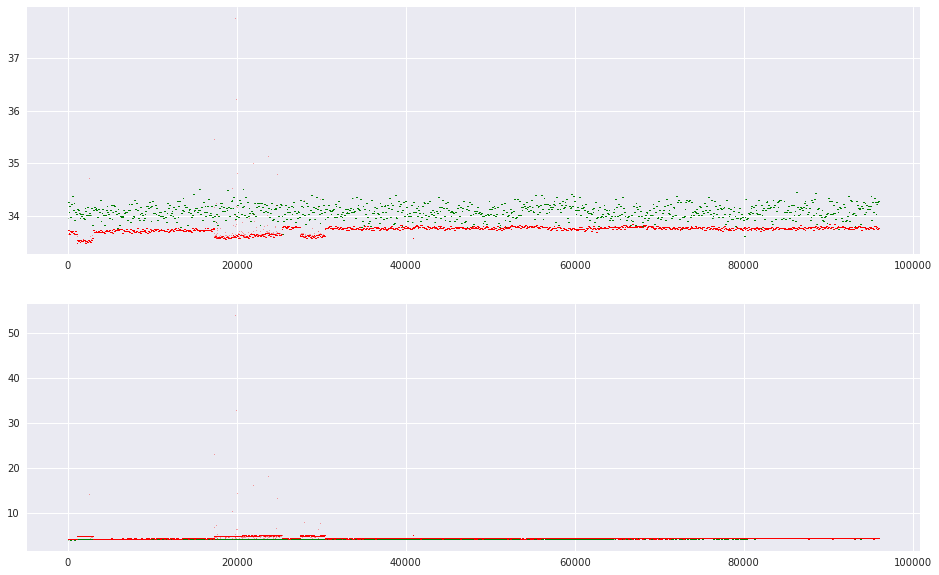

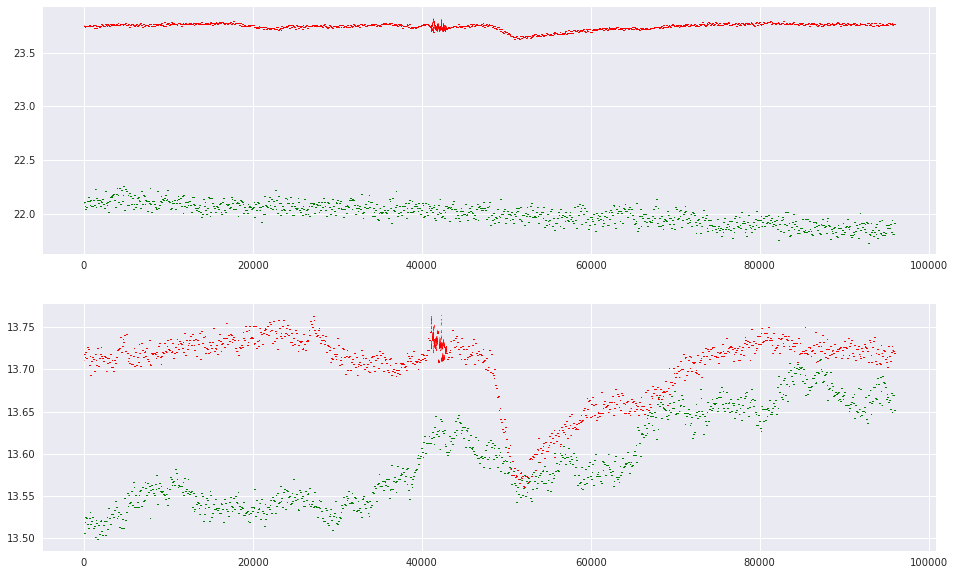

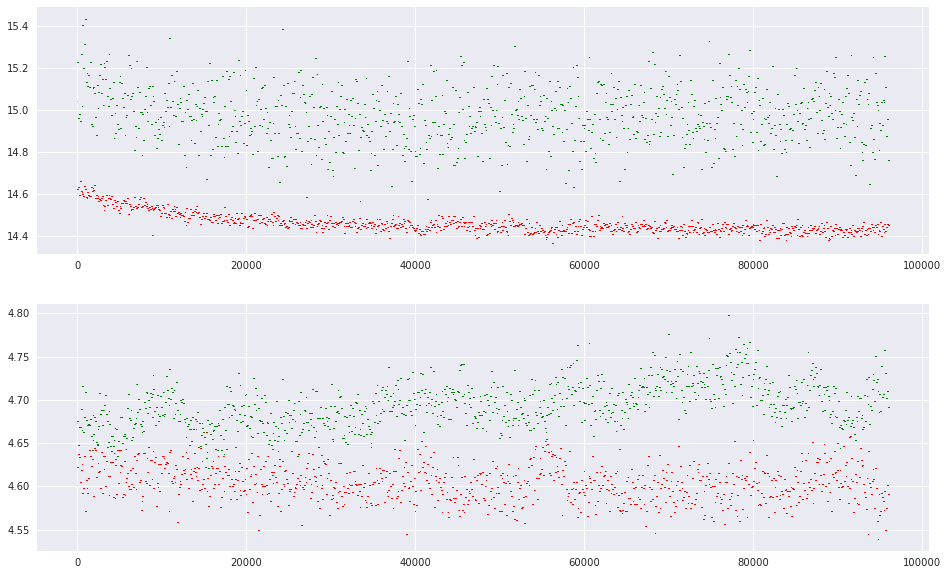

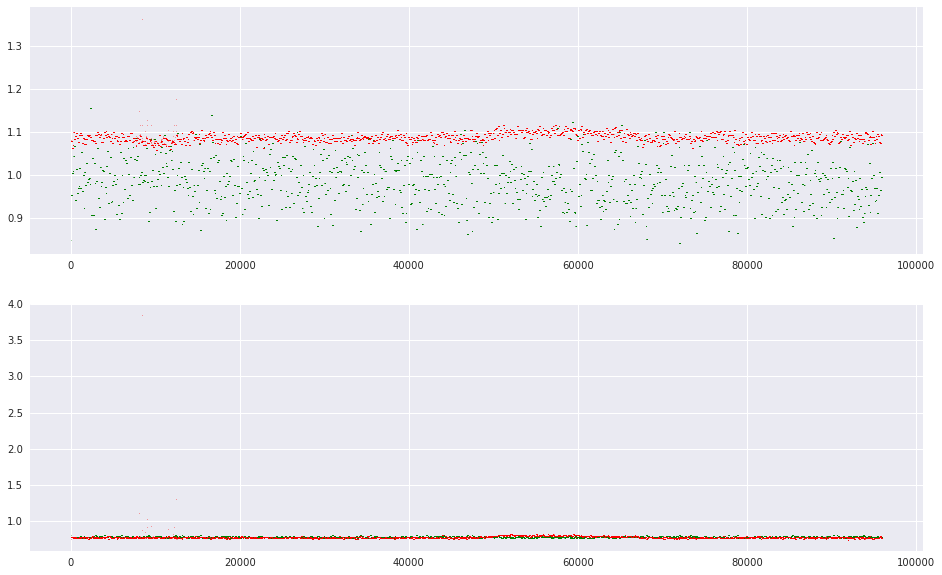

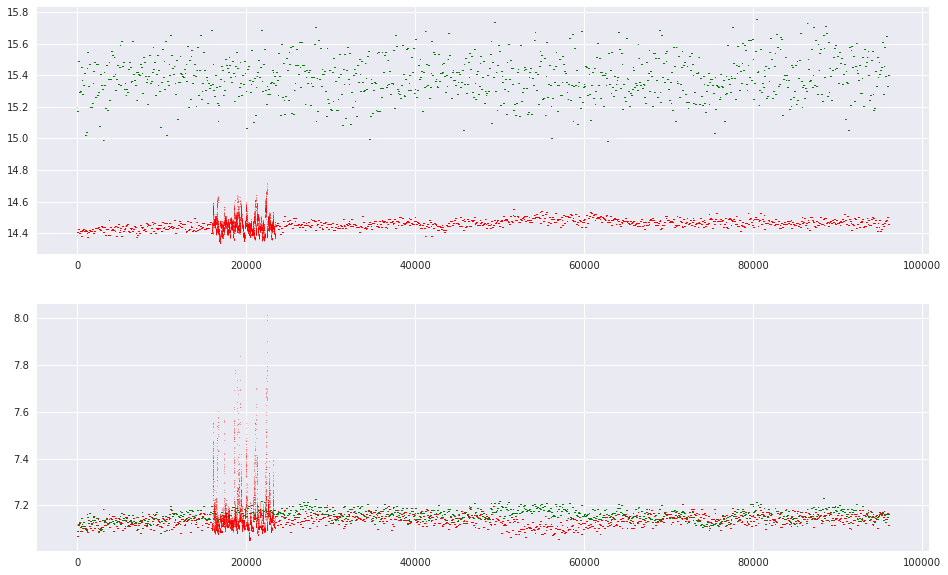

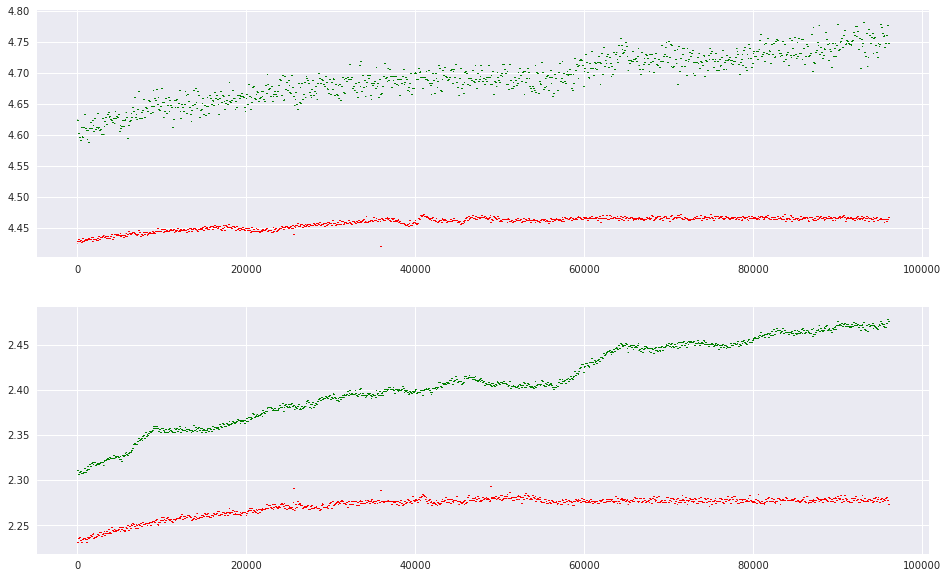

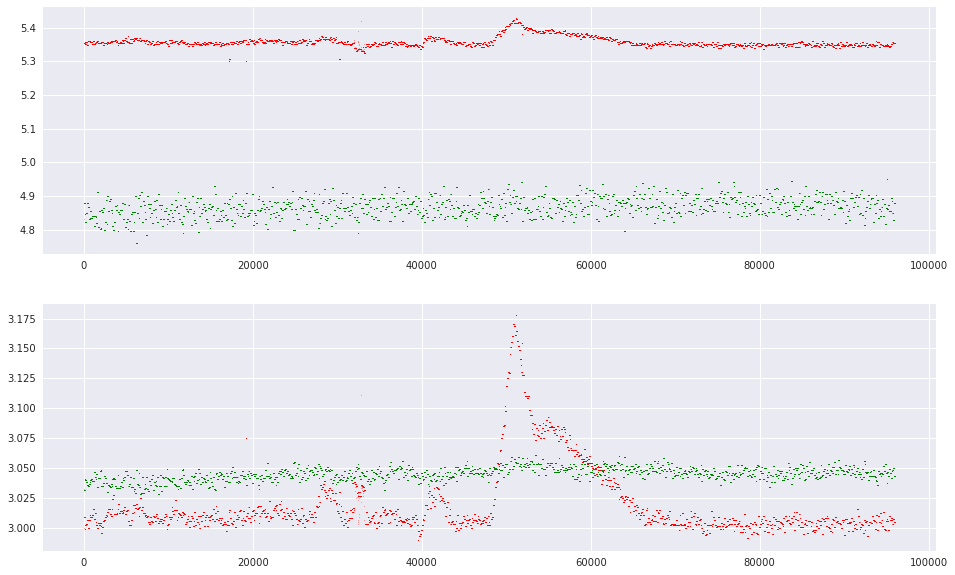

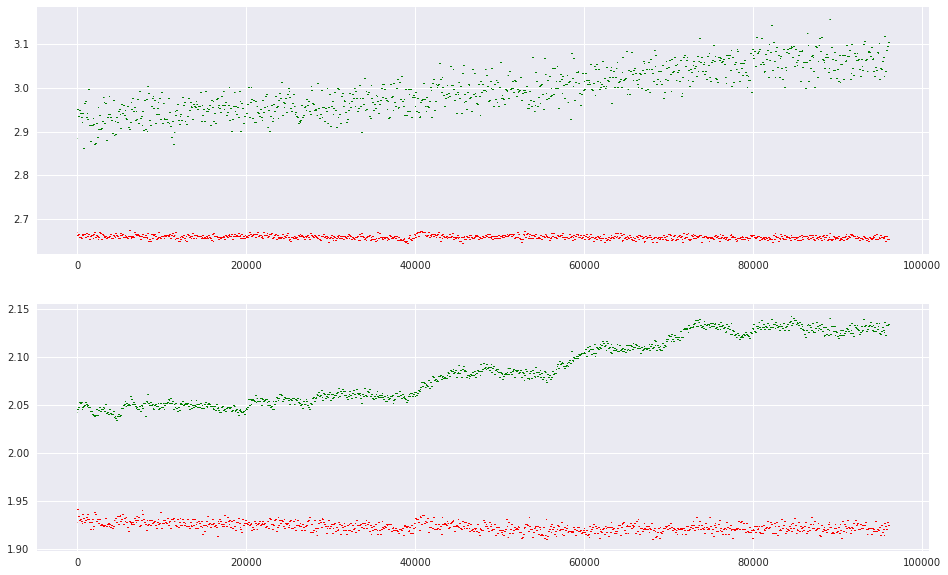

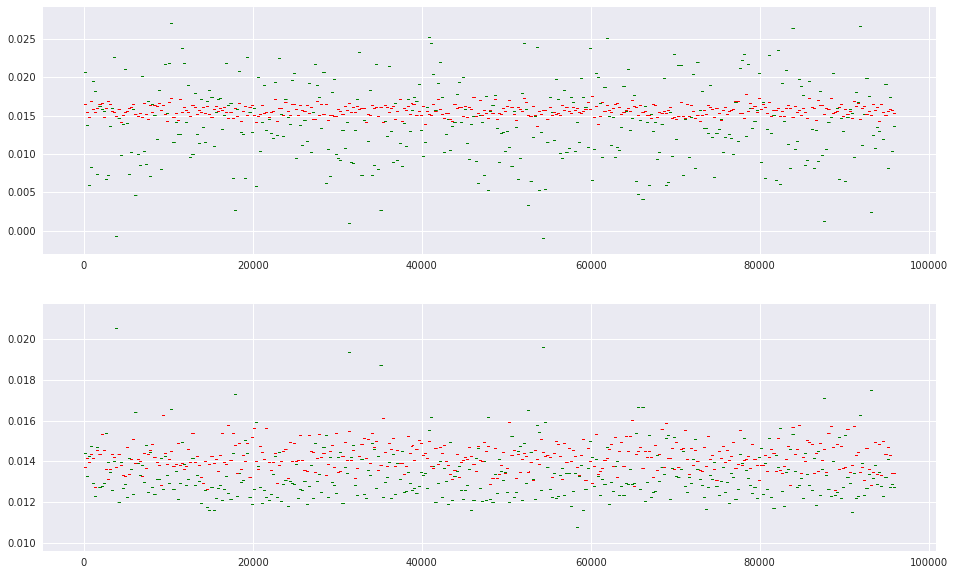

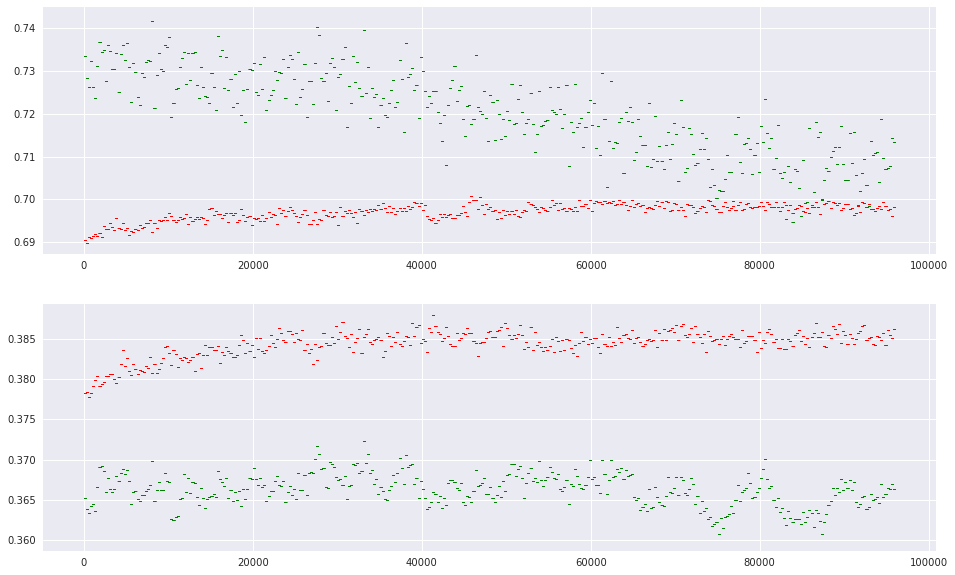

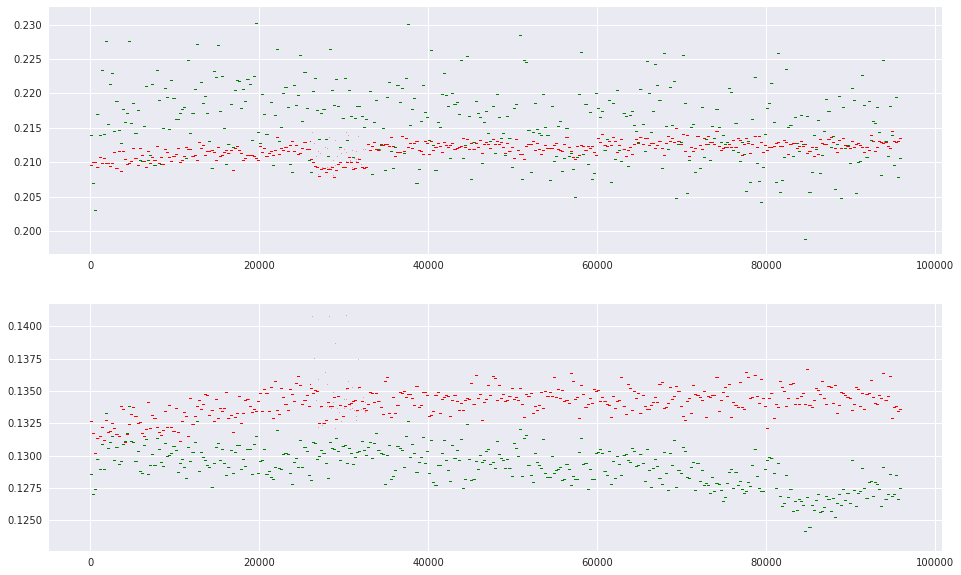

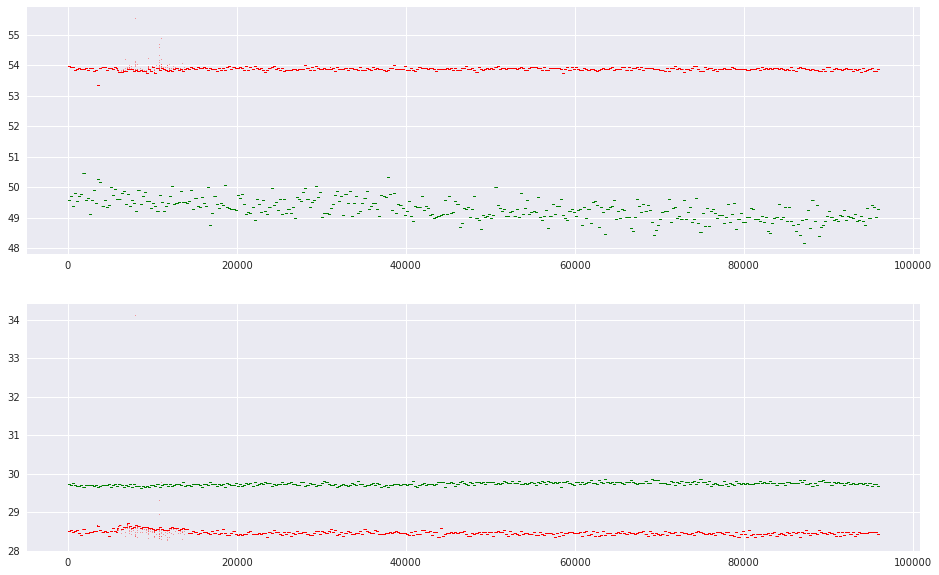

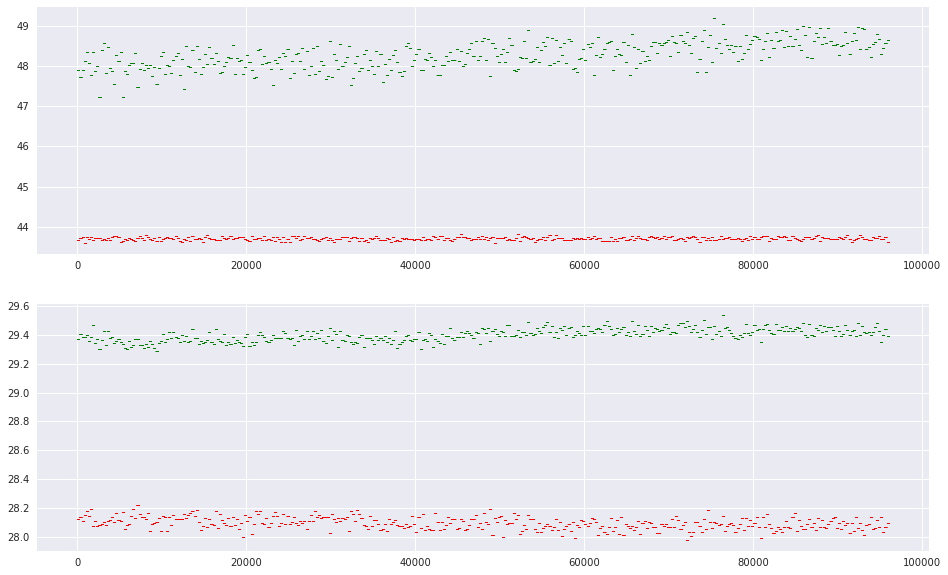

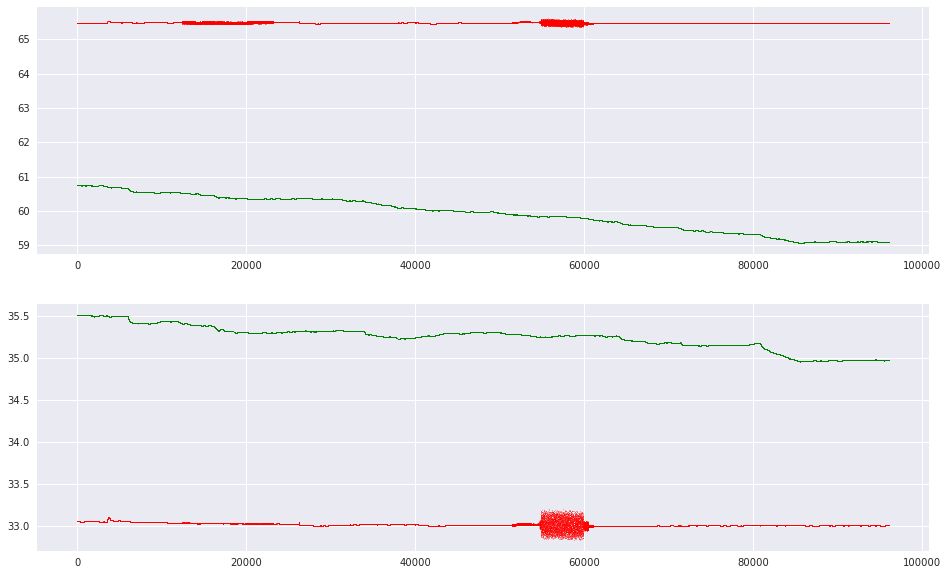

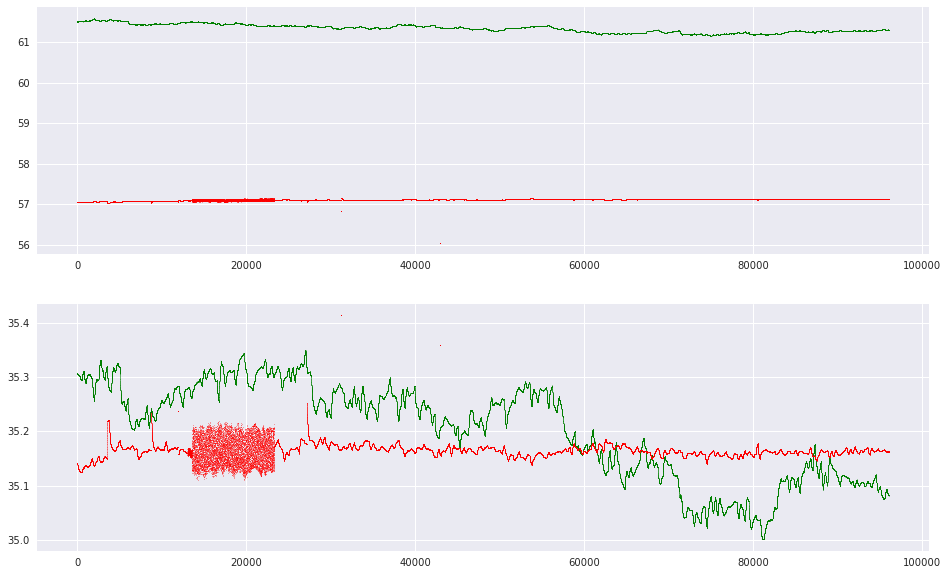

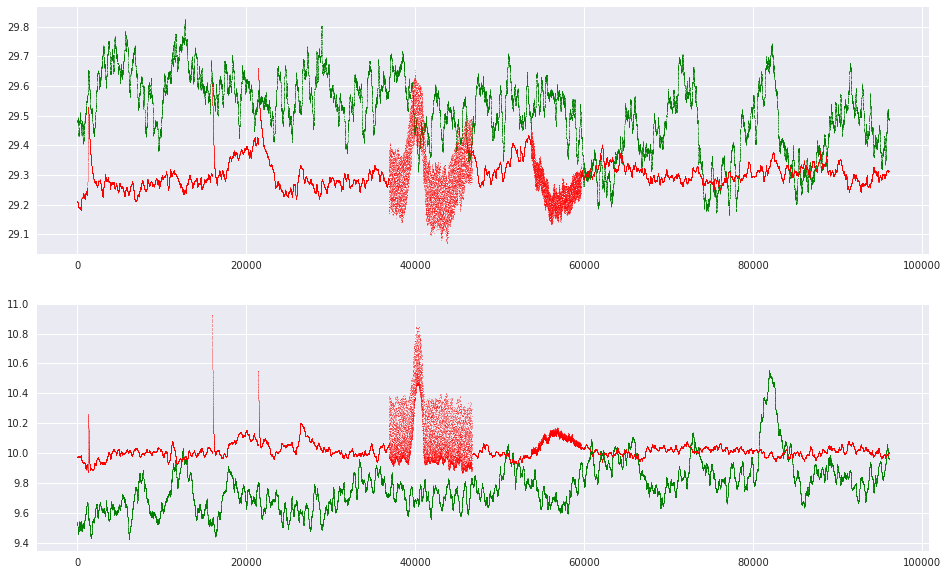

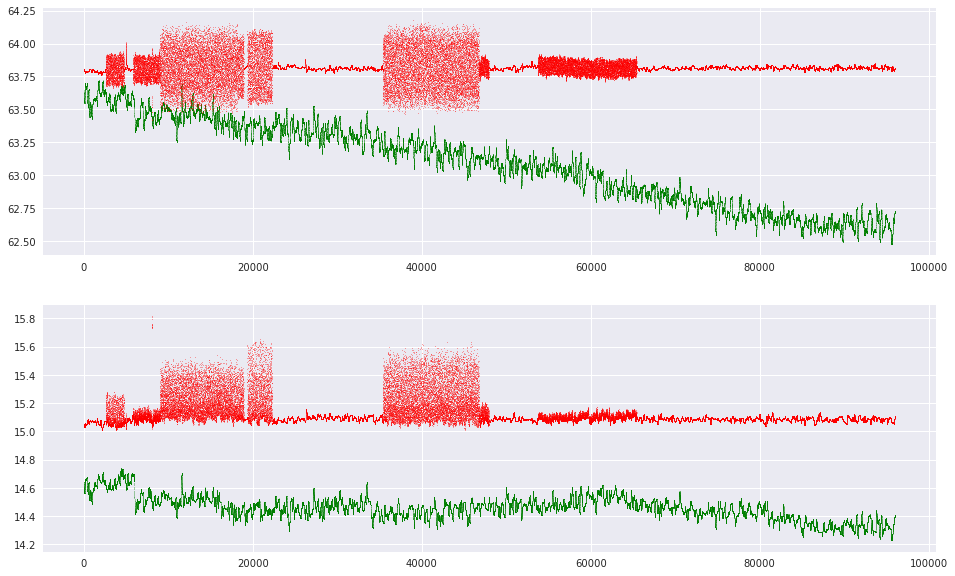

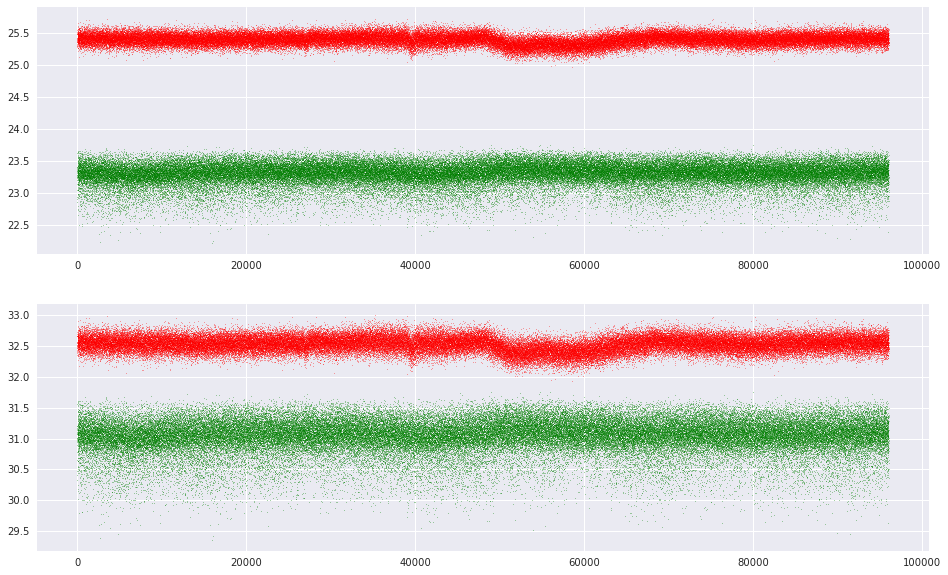

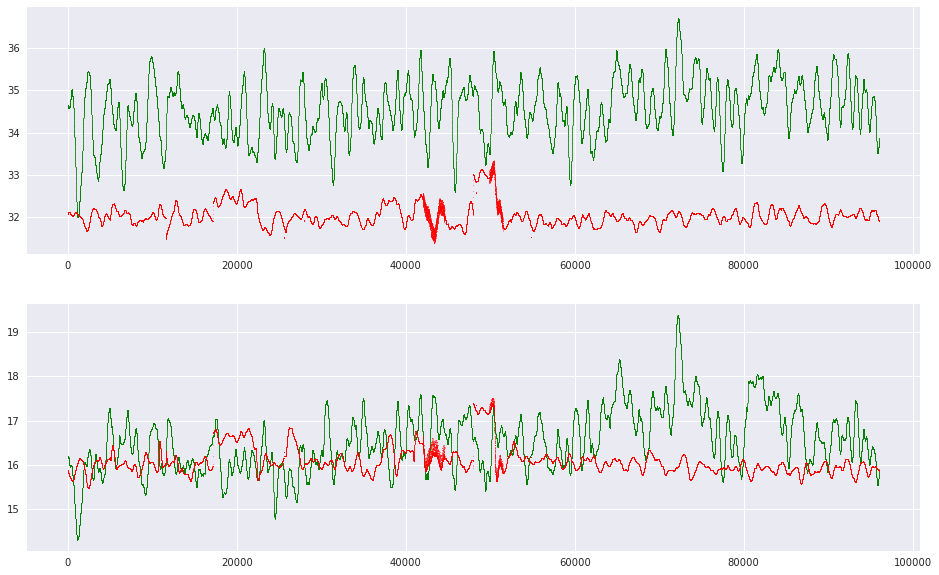

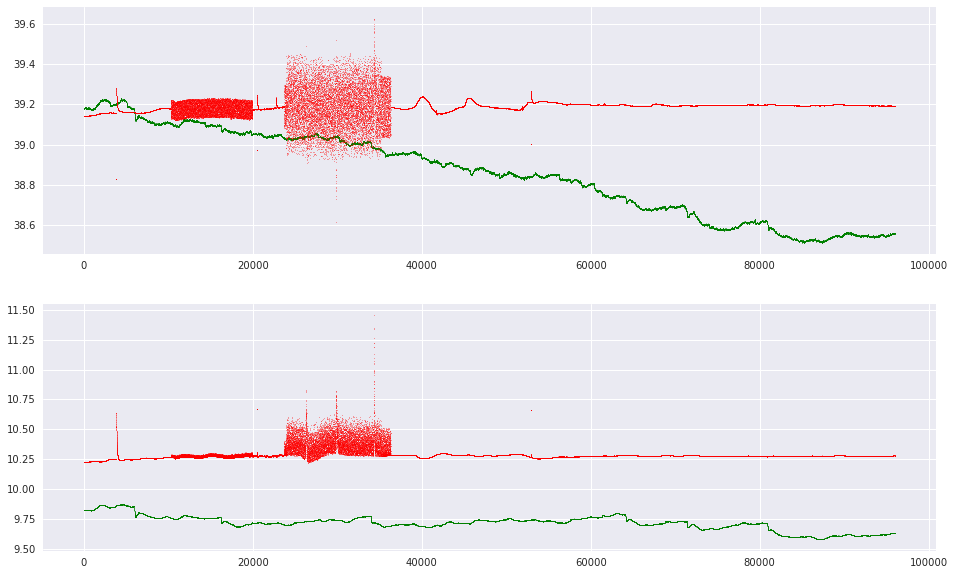

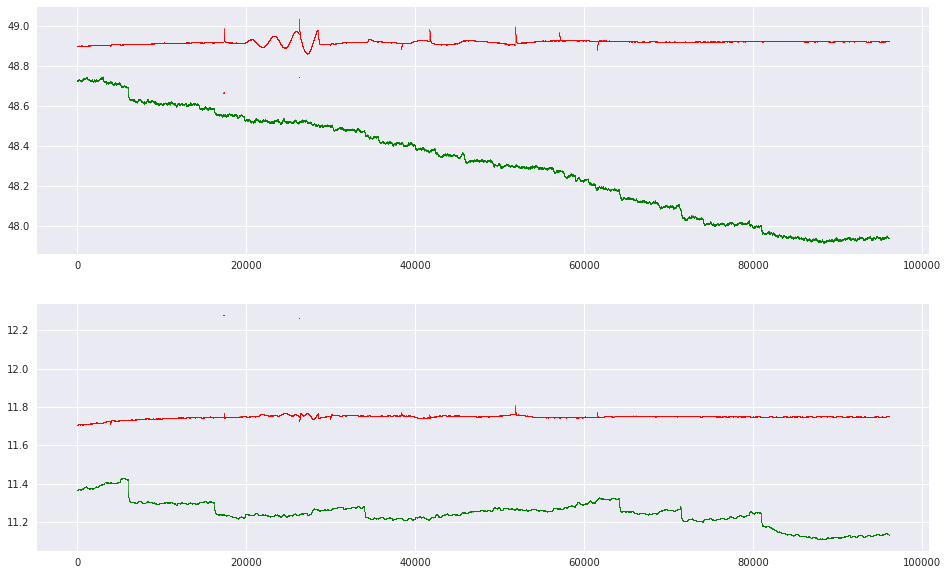

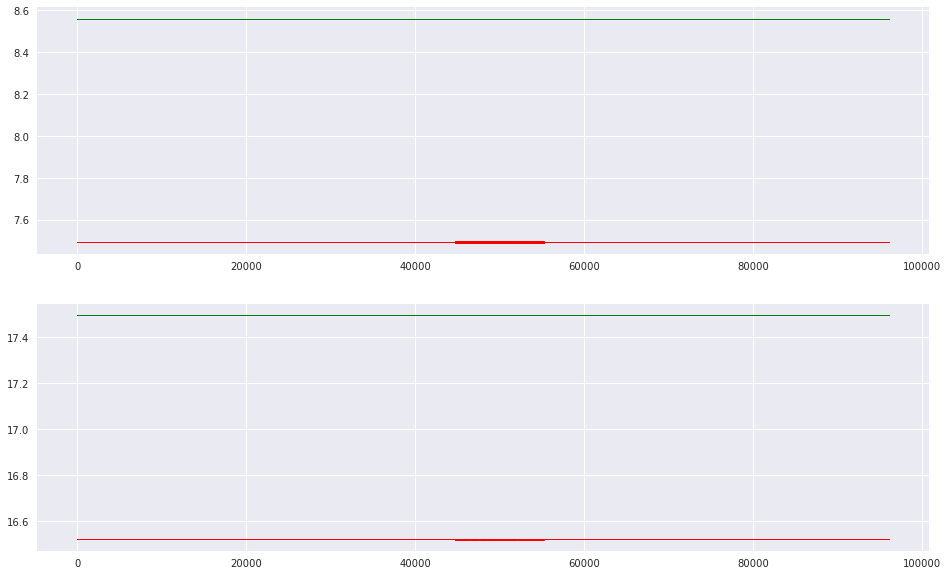

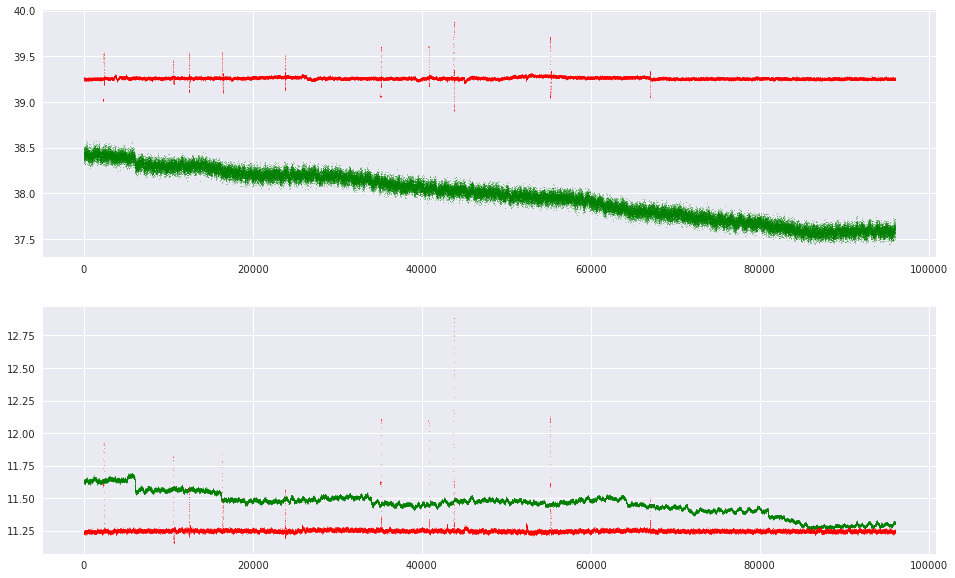

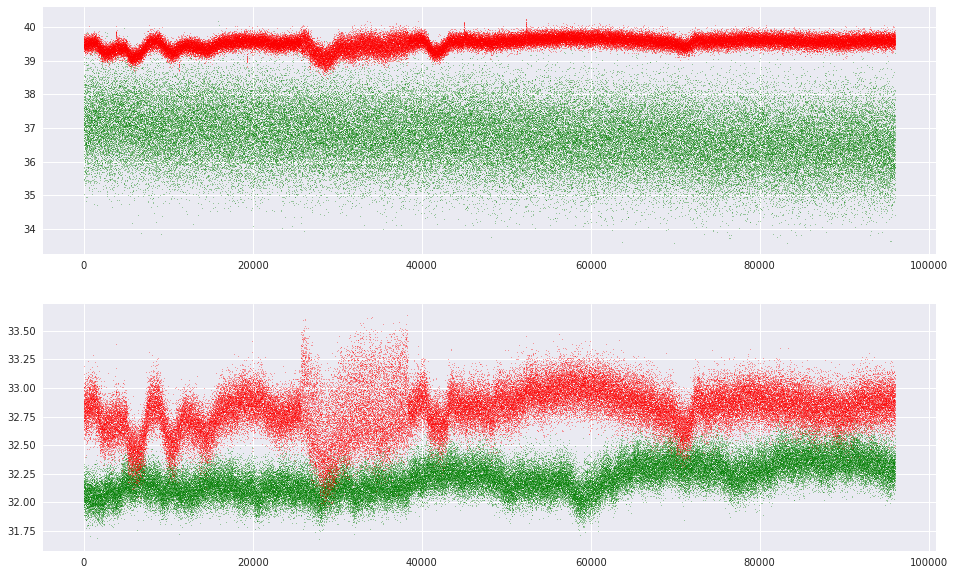

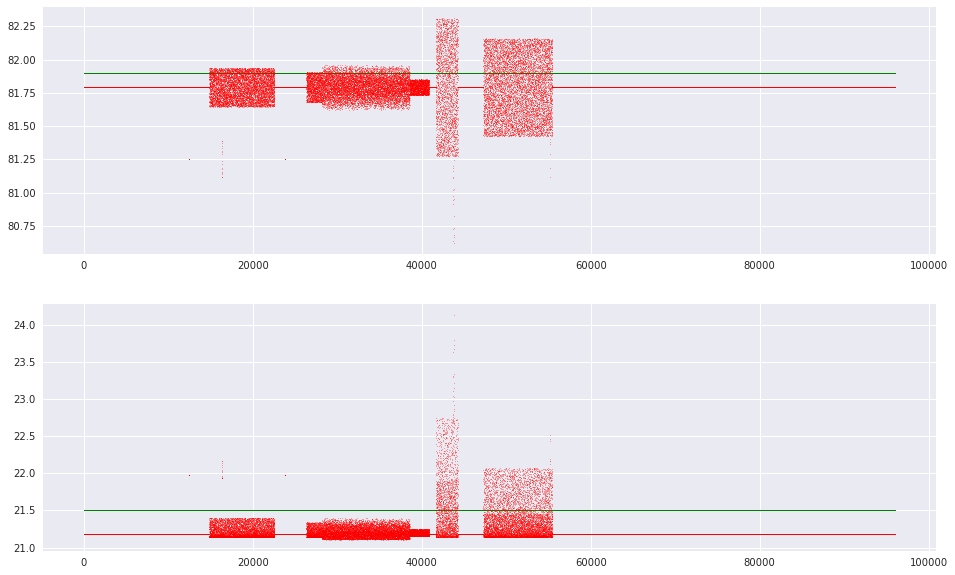

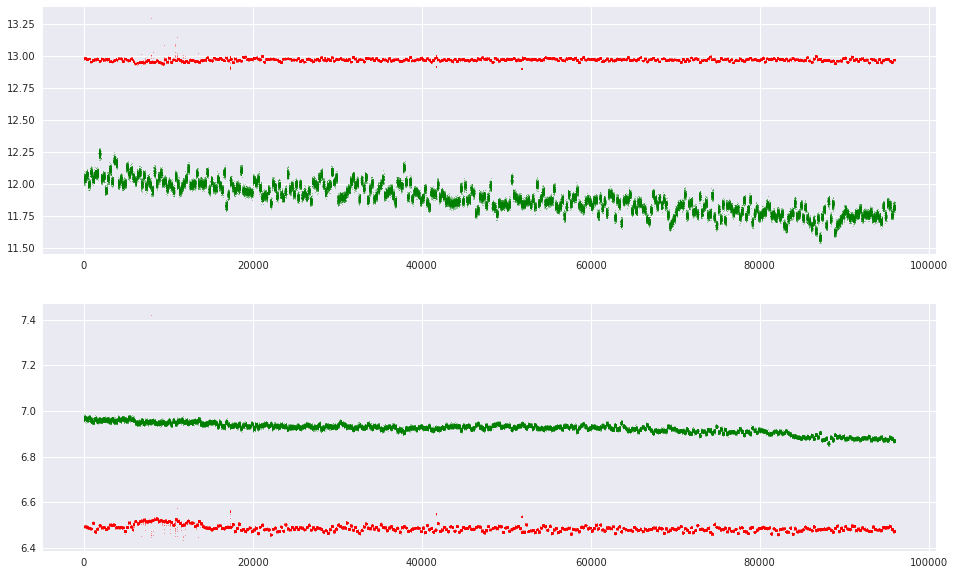

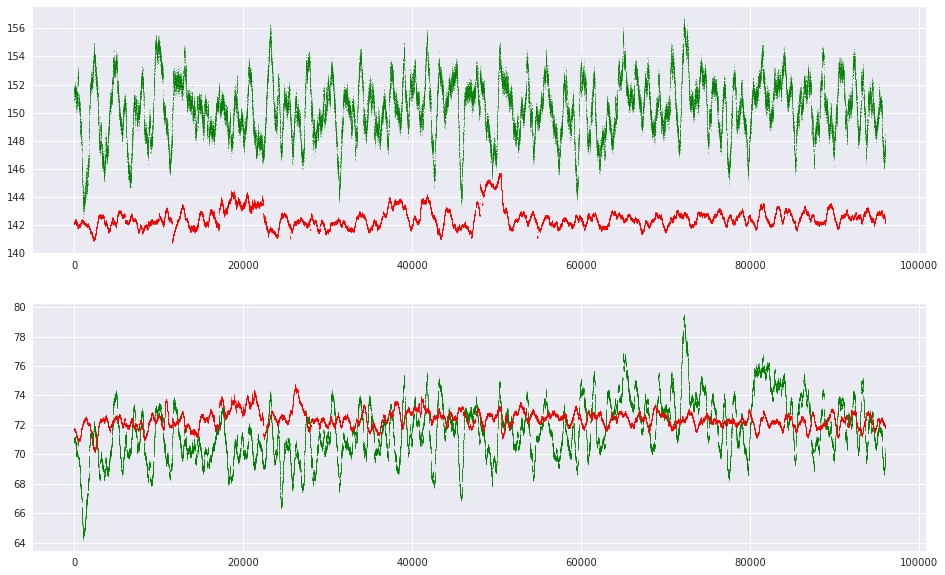

In [75]:
for col in range(dfs_0[0].shape[1]):
    
    print col
    plt.figure(figsize=(16,10))
    plt.subplot(2, 1, 1)

    dfs_col_0 = np.array([df[col] for df in dfs_0]).T
    dfs_col_1 = np.array([df[col] for df in dfs_1]).T


    plt.scatter(range(dfs_col_0.shape[0]), dfs_col_0.mean(axis=1), c= "g", s=0.1)
    plt.scatter(range(dfs_col_0.shape[0]), dfs_col_1.mean(axis=1), c="r", s=0.1)

    plt.subplot(2, 1, 2)
    plt.scatter(range(dfs_col_0.shape[0]), dfs_col_0.std(axis=1), c= "g", s=0.1)
    plt.scatter(range(dfs_col_1.shape[0]), dfs_col_1.std(axis=1), c="r", s=0.1)

In [47]:
dfs_col_0.shape

(96000, 315)

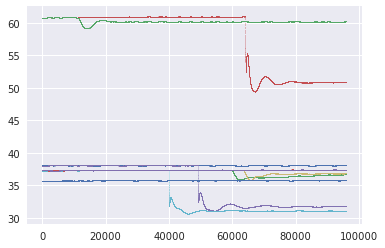

In [67]:
for i in range(30, 40):
    plt.scatter(range(dfs_col_0.shape[0]), dfs_col_0[:,i], s=0.1)

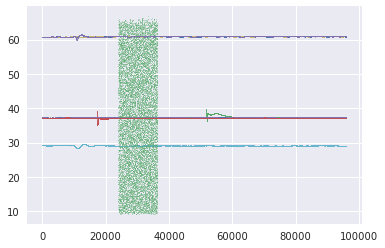

In [69]:
for i in range(25, 35):
    plt.scatter(range(dfs_col_1.shape[0]), dfs_col_1[:,i], s=0.1)

In [ ]:
for col in range(dfs_0[0].shape[1]):
    
    print col
    plt.figure(figsize=(16,10))
    plt.subplot(2, 1, 1)
    
    for df in dfs_0:
        stds = df.rolling(window = 500, min_periods=1).std()
        maxs = stds.max(axis=0)
    v = []
    v.append(list(maxs))
    
    dfs_col_0 = np.array([df[col] for df in dfs_0]).T
    dfs_col_1 = np.array([df[col] for df in dfs_1]).T


    plt.scatter(range(dfs_col_0.shape[0]), dfs_col_0.mean(axis=1), c= "g", s=0.1)
    plt.scatter(range(dfs_col_0.shape[0]), dfs_col_1.mean(axis=1), c="r", s=0.1)

    plt.subplot(2, 1, 2)
    stds = dfs_col_0.std(axis=1)
    
    plt.scatter(range(dfs_col_0.shape[0]), dfs_col_0.std(axis=1), c= "g", s=0.1)
    plt.scatter(range(dfs_col_1.shape[0]), dfs_col_1.std(axis=1), c="r", s=0.1)